# Bayesian Linear Regression
Based on the Seoul Bike Sharing Demand dataset located at ../data/SeoulBikeData.csv
Load the data and split into train and test sets, 80% for training and 20% for testing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pymc as pm
import arviz as az

Data Preprocessing, make sure to convert the categorical variables into numeric variables.

In [57]:
file_path = '../data/SeoulBikeData.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')
numeric_season = {'Spring' : 1, 'Summer' : 2, 'Autumn' : 3, 'Winter' : 4}
numeric_holiday = {'No Holiday' : 0, 'Holiday' : 1}
numeric_functioning_day = {'No' : 0, 'Yes' : 1}
df['Seasons'] = df['Seasons'].map(numeric_season)
df['Holiday'] = df['Holiday'].map(numeric_holiday)
df['Functioning Day'] = df['Functioning Day'].map(numeric_functioning_day)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['DayOfWeek'] = df['Date'].dt.dayofweek
# df['Month'] = df['Date'].dt.month
# df['Year'] = df['Date'].dt.year
df.drop('Date', axis=1, inplace=True)

print(df.head())
X = df.drop(['Rented Bike Count'], axis=1)
y = df['Rented Bike Count']
print(df.shape)
print(X.shape)
print(y.shape)
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
0                254     0             -5.2           37               2.2   
1                204     1             -5.5           38               0.8   
2                173     2             -6.0           39               1.0   
3                107     3             -6.2           40               0.9   
4                 78     4             -6.0           36               2.3   

   Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
0              2000                      -17.6                      0.0   
1              2000                      -17.6                      0.0   
2              2000                      -17.7                      0.0   
3              2000                      -17.6                      0.0   
4              2000                      -18.6                      0.0   

   Rainfall(mm)  Snowfall (cm)  Seasons  Holiday  Functioning Day  DayOfWeek  
0

In [77]:
# scale the data
scaler = StandardScaler()
columns_to_scale = X.columns.difference(['Seasons', 'Holiday', 'Functioning Day', 'DayOfWeek'])
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

X_train_np = X_train.to_numpy(dtype=np.float32)
X_test_np = X_test.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.float32)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print(X_train.head())
print(X_train.describe())

Training set size: (7008, 13)
Test set size: (1752, 13)
          Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
8415  0.505421         0.022370     0.137012          2.092940   
5049 -0.363566         0.838222     1.359982         -0.029683   
8395  1.084745        -0.145847    -0.596770         -0.319131   
1535  1.664070        -1.306543     0.528362          0.259766   
5518  1.519239         1.199888     0.724038         -0.222648   

      Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
8415         -1.176113                   0.130553                 0.519701   
5049         -1.472667                   1.255469                 0.210677   
8395         -0.930350                  -0.316331                -0.659168   
1535         -0.004643                  -0.894198                -0.659168   
5518         -0.707525                   1.371043                -0.659168   

      Rainfall(mm)  Snowfall (cm)  Seasons  Holiday  Functioning Day  \
8415  

#### Bayesian Linear Regression
Use PyMC to perform Bayesian Linear Regression on your new dataset. 

In [102]:
y_train_log = np.log(y_train + 1)  # Add 1 to avoid log(0)

num_samples = 1000

with pm.Model() as model:
    n_features = X_train.shape[1]  # Number of features in X_train

    # Adjusted priors for the regression coefficients based on standardized features
    beta = pm.Normal('beta', mu=0, sigma=1, shape=n_features)
    alpha = pm.Normal('alpha', mu=0, sigma=0.5)  # Assuming the mean of y_train_log is around 0 after log transformation
    sigma = pm.Exponential('sigma', 1)

    # Expected value of outcome (in log scale)
    mu_log = alpha + pm.math.dot(X_train, beta)

    # Model the outcome variable in log scale
    Y_obs_log = pm.Normal('Y_obs_log', mu=mu_log, sigma=sigma, observed=y_train_log)

    # Sample from the posterior
    trace = pm.sample(num_samples, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


Posterior Predictive Check, plot the posterior predictive distribution of the model

<Figure size 1000x1000 with 0 Axes>

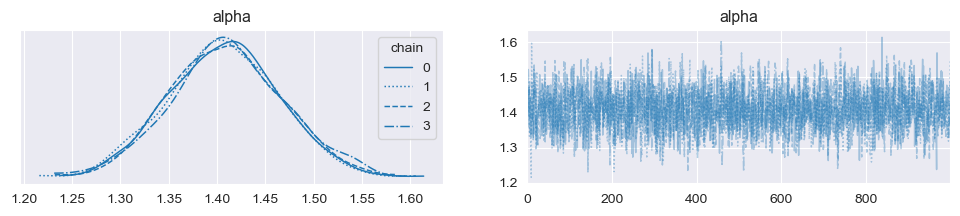

<Figure size 1000x1000 with 0 Axes>

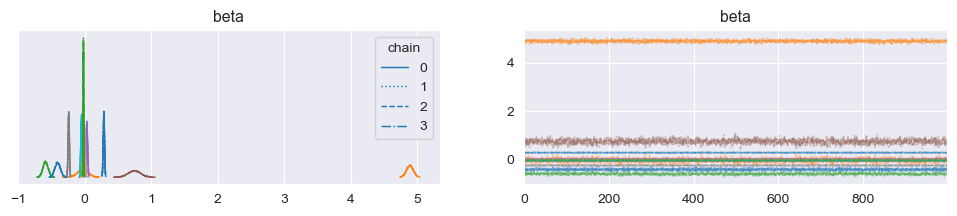

<Figure size 1000x1000 with 0 Axes>

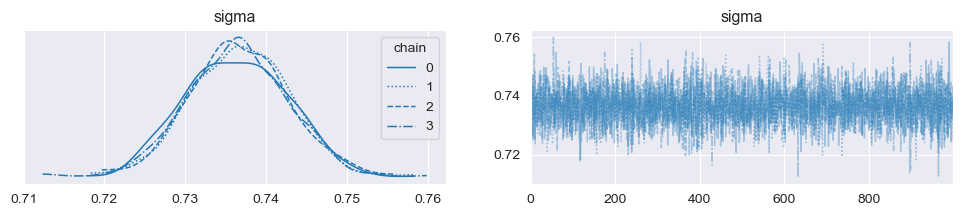

In [103]:
plt.figure(figsize=(10, 10))
az.plot_trace(trace, combined=False, var_names=['alpha'], legend=True)
plt.show()
plt.figure(figsize=(10, 10))
az.plot_trace(trace, combined=False, var_names=['beta'], legend=True)
plt.show()
plt.figure(figsize=(10, 10))
az.plot_trace(trace, combined=False, var_names=['sigma'], legend=True)
plt.show()

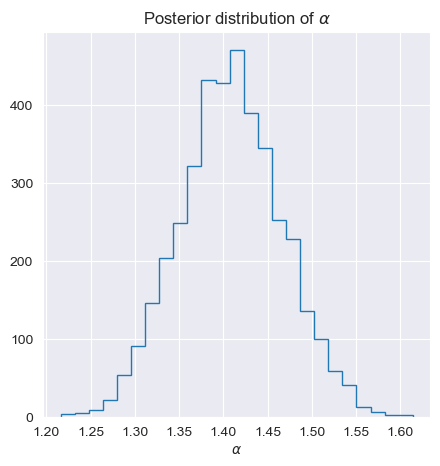

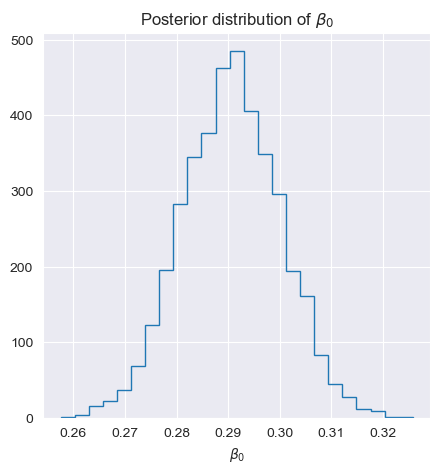

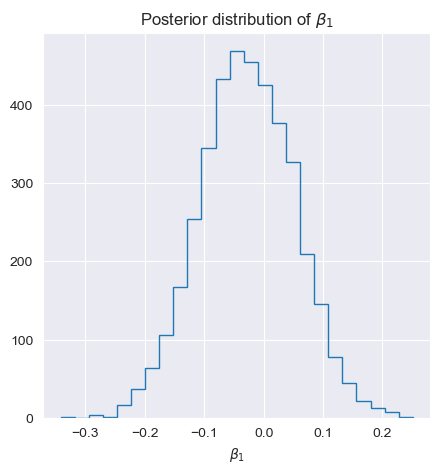

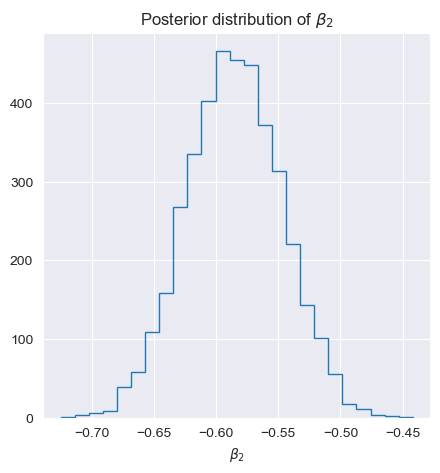

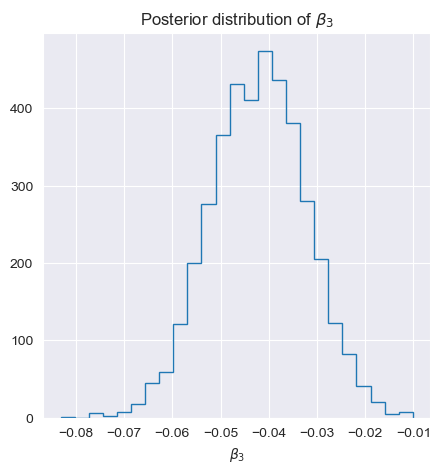

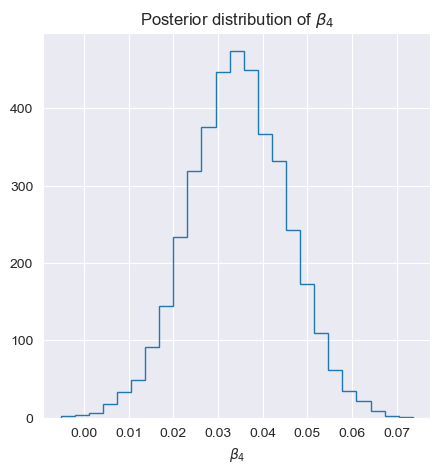

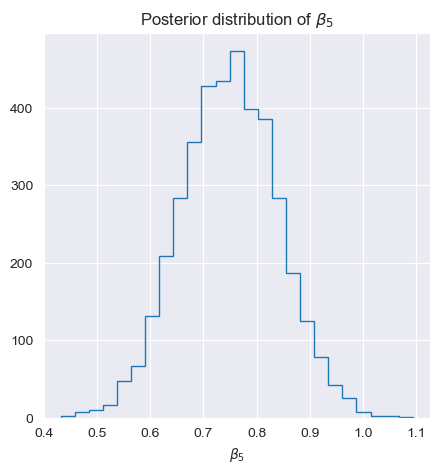

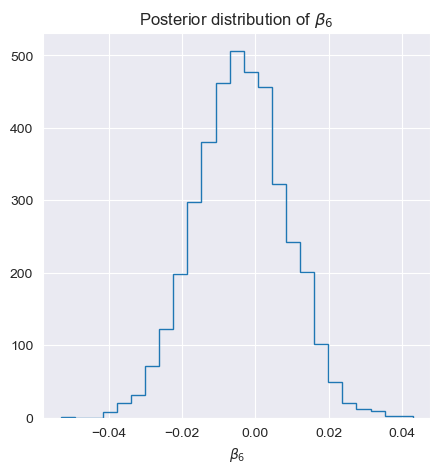

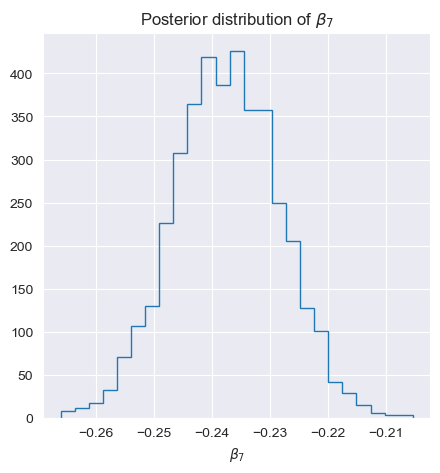

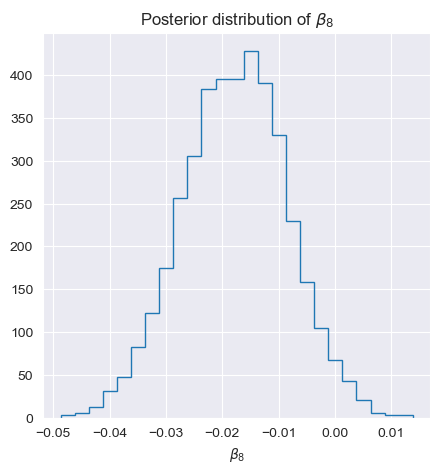

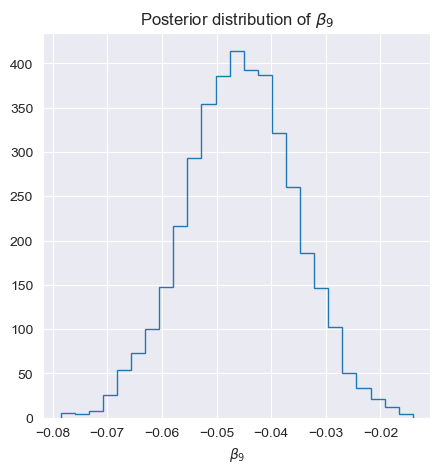

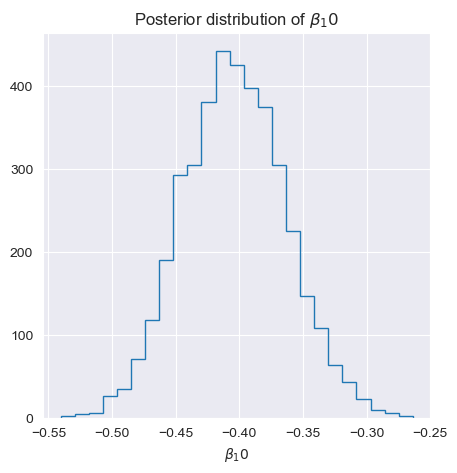

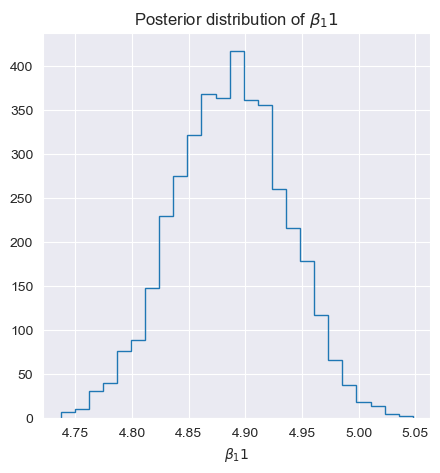

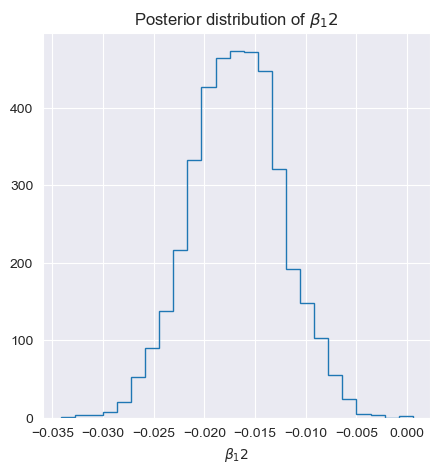

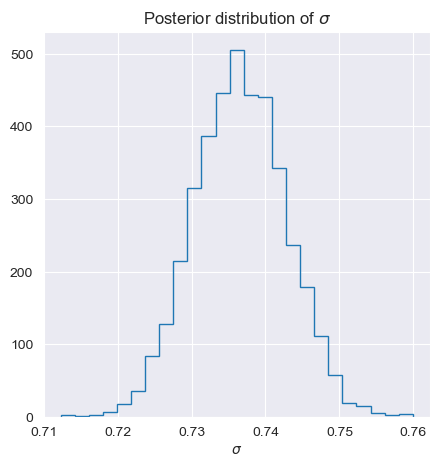

In [104]:
# plot the posterior distributions
plt.figure(figsize=(5, 5))
plt.hist(trace.posterior['alpha'].values.flatten(), bins=25, histtype='step')
plt.xlabel('$\\alpha$')
plt.title('Posterior distribution of $\\alpha$')
plt.show()

# for 13 betas in the model 
for i in range(trace.posterior['beta'].shape[-1]):
    plt.figure(figsize=(5, 5))
    plt.hist(trace.posterior['beta'].sel(beta_dim_0=i).values.flatten(), bins=25, histtype='step')
    plt.xlabel(f'$\\beta_{i}$')
    plt.title(f'Posterior distribution of $\\beta_{i}$')
    plt.show()


plt.figure(figsize=(5, 5))
plt.hist(trace.posterior['sigma'].values.flatten(), bins=25, histtype='step')
plt.xlabel('$\\sigma$')
plt.title('Posterior distribution of $\\sigma$')
plt.show()


Summery posterior mean value for each model parameter generated by arviz.summary

In [105]:
# print the summary of the posterior distribution
summary = az.summary(trace)
print(summary)

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]   0.291  0.009   0.274    0.309      0.000    0.000    3988.0   
beta[1]  -0.027  0.079  -0.176    0.122      0.002    0.001    1473.0   
beta[2]  -0.585  0.038  -0.657   -0.515      0.001    0.001    1588.0   
beta[3]  -0.042  0.010  -0.061   -0.024      0.000    0.000    4200.0   
beta[4]   0.035  0.011   0.014    0.055      0.000    0.000    4051.0   
beta[5]   0.749  0.091   0.587    0.928      0.002    0.002    1476.0   
beta[6]  -0.004  0.012  -0.027    0.019      0.000    0.000    3607.0   
beta[7]  -0.237  0.009  -0.254   -0.220      0.000    0.000    4236.0   
beta[8]  -0.018  0.009  -0.035   -0.001      0.000    0.000    5323.0   
beta[9]  -0.046  0.010  -0.064   -0.026      0.000    0.000    3924.0   
beta[10] -0.404  0.040  -0.479   -0.329      0.001    0.000    5000.0   
beta[11]  4.887  0.049   4.789    4.973      0.001    0.001    2641.0   
beta[12] -0.017  0.004  -0.025   -0.008      0.000 

Sampling: [Y_obs_log]


<Axes: xlabel='Y_obs_log / Y_obs_log'>

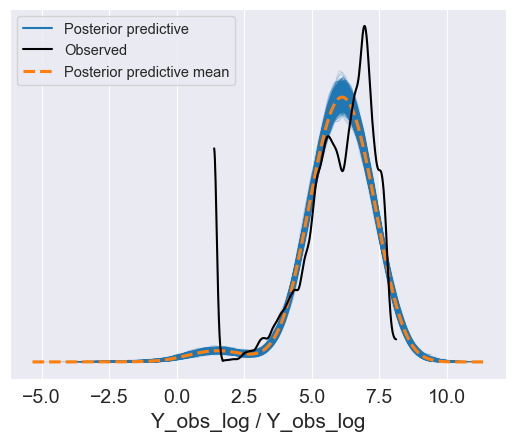

In [106]:
y_pred = []
with model:
    y_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

az.plot_ppc(y_pred)